This code sets up a VAE with a 360-dimensional input, 128-dimensional latent space, and a single hidden layer in both the encoder and decoder. The vae_loss function combines reconstruction loss and KL divergence loss. The model is then compiled using an Adam optimizer.






In [19]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.losses import mse
from keras import backend as K
from keras.optimizers import Adam
import numpy as np

# Define the dimensions
original_dim = 360
intermediate_dim = 128
latent_dim = 2
batch_size = 32
epochs = 50

# Custom sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder network
inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Sample z
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Instantiate encoder
encoder = Model(inputs, [z_mean, z_log_var, z])

# Decoder network
latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='linear')(x)  # Change activation function to linear


# Instantiate decoder
decoder = Model(latent_inputs, outputs)

# VAE model
outputs = decoder(z)
vae = Model(inputs, outputs)

# Define the loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

# Compile the model
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam())

In [20]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['loss']
    #kl_loss = history.history['kl_loss']
    #reconstruction_loss = history.history['reconstruction_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'b', label='Total loss')
    #plt.plot(epochs, kl_loss, 'g', label='KL divergence')
    #plt.plot(epochs, reconstruction_loss, 'r', label='Reconstruction loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_waveforms(original, reconstructed):
    plt.figure(figsize=(10, 5))
    plt.plot(original[0], label='Original')
    plt.plot(reconstructed[0], label='Reconstructed')
    plt.title('Original vs Reconstructed Waveforms')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

(1000, 360)
Epoch 1/50
32/32 [==============================] - 0s 4ms/step - loss: 1.7751
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 1.7189
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 1.7744
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 1.8091
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 1.7798
Epoch 6/50
32/32 [==============================] - 0s 4ms/step - loss: 1.7876
Epoch 7/50
32/32 [==============================] - 0s 3ms/step - loss: 1.7774
Epoch 8/50
32/32 [==============================] - 0s 3ms/step - loss: 1.7761
Epoch 9/50
32/32 [==============================] - 0s 3ms/step - loss: 1.8583
Epoch 10/50
32/32 [==============================] - 0s 4ms/step - loss: 1.7457
Epoch 11/50
32/32 [==============================] - 0s 6ms/step - loss: 1.8225
Epoch 12/50
32/32 [==============================] - 0s 6ms/step - loss: 1.8062
Epoch 13/50
32/32 [==================

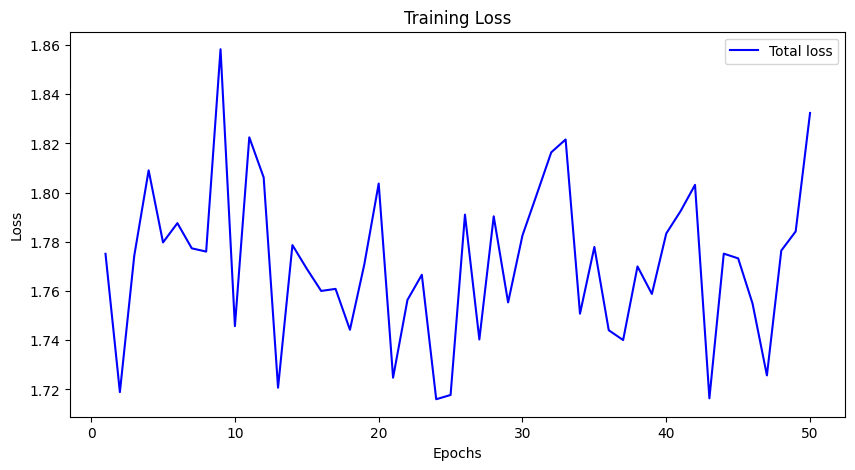

In [32]:
def generate_interpolated_waveform(num_points=360, interpolation_factor=0.5):
    x_values = np.linspace(0, 2*np.pi, num_points)
    sine_wave = np.sin(x_values)
    square_wave = np.sign(np.sin(x_values))
    interpolated_wave = interpolation_factor * sine_wave + (1 - interpolation_factor) * square_wave
    return interpolated_wave

def generate_multiple_waveform_arrays(num_arrays=1000, num_points=360):
    waveform_arrays = []
    for _ in range(num_arrays):
        interpolation_factor = np.random.uniform(0, 1)  # Randomly sample interpolation factors
        waveform_array = np.array(generate_interpolated_waveform(num_points=num_points, interpolation_factor=interpolation_factor))
        waveform_arrays.append(waveform_array)
    return np.array(waveform_arrays)


print(generate_multiple_waveform_arrays().shape)
x_train = generate_multiple_waveform_arrays()

# Train the VAE
history = vae.fit(x_train, epochs=epochs, batch_size=batch_size)

# Plot the loss
plot_loss(history)



1/1 [==============================] - 0s 64ms/step


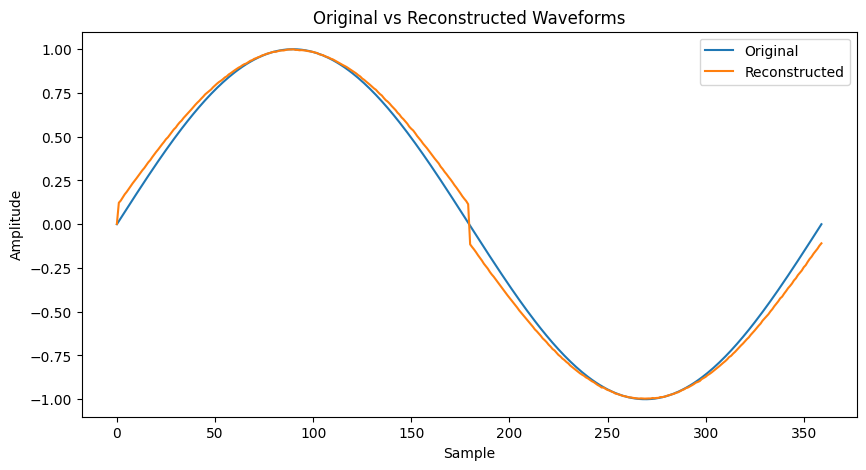

In [38]:
def plot_waveform_comparison(original_waveform, reconstructed_waveform):
    plt.figure(figsize=(10, 5))
    plt.plot(original_waveform, label='Original')
    plt.plot(reconstructed_waveform, label='Reconstructed')
    plt.title('Original vs Reconstructed Waveforms')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Example usage:
original_waveform = generate_interpolated_waveform(360,1)
reconstructed_waveform = vae.predict(np.array([original_waveform]))[0]  # Reconstruct the waveform
plot_waveform_comparison(original_waveform, reconstructed_waveform)

1/1 [==============================] - 0s 21ms/step


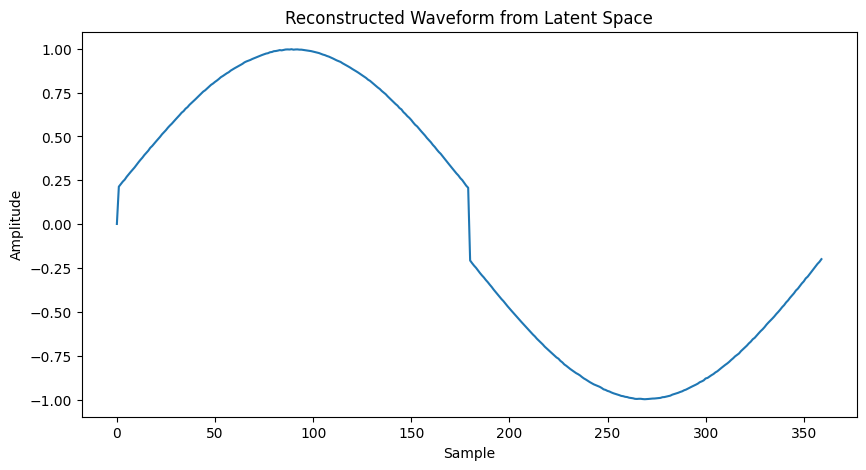

In [40]:

# Function to sample from latent space
def sample_from_latent_space():
    latent_dim = 2  # Assuming latent dimension is 2
    latent_point = np.random.normal(size=(1, latent_dim))
    return latent_point

# Function to decode a latent point into a waveform
def decode_latent_point(latent_point):
    reconstructed_waveform = decoder.predict(latent_point)
    return reconstructed_waveform

# Sample from latent space
latent_point = sample_from_latent_space()

# Decode latent point into a waveform
reconstructed_waveform = decode_latent_point(latent_point)

# Plot the reconstructed waveform
plt.figure(figsize=(10, 5))
plt.plot(reconstructed_waveform[0])
plt.title('Reconstructed Waveform from Latent Space')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()
